<a href="https://colab.research.google.com/github/deep-diver/keras-sd-serving/blob/main/inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U tensorflow
!pip install keras-cv

In [1]:
import json

def is_jsonable(x):
    try:
        json.dumps(x)
        return True
    except (TypeError, OverflowError):
        return False

In [2]:
import matplotlib.pyplot as plt

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

In [3]:
import requests
import PIL

from io import BytesIO

def download_image(url, mode="RGB"):
  response = requests.get(url)
  return PIL.Image.open(BytesIO(response.content)).convert(mode)

In [4]:
BATCH_SIZE = 4

In [5]:
REPO_ID = "keras-sd/text-encoder"

In [6]:
!git lfs install
!git clone https://huggingface.co/{REPO_ID}

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
fatal: destination path 'text-encoder' already exists and is not an empty directory.


In [7]:
import importlib

handler = importlib.import_module("text-encoder.handler")

my_handler = handler.EndpointHandler(path=".")

payload = {"inputs": "Face of a yellow cat, high resolution, sitting on a park bench",
           "batch_size": 4}

response = my_handler(payload)

In [8]:
print(is_jsonable(response["context_b64str"]))
print(is_jsonable(response["unconditional_context_b64str"]))

True
True


In [9]:
import base64
import numpy as np

context = base64.b64decode(response["context_b64str"])
context = np.frombuffer(context, dtype="float32")
context = np.reshape(context, (BATCH_SIZE, 77, 768))

unconditional_context = base64.b64decode(response["unconditional_context_b64str"])
unconditional_context = np.frombuffer(unconditional_context, dtype="float32")
unconditional_context = np.reshape(unconditional_context, (BATCH_SIZE, 77, 768))    

In [10]:
img_url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

In [11]:
img_height = 512
img_width = 512
img_height = round(img_height / 128) * 128
img_width = round(img_width / 128) * 128

image = download_image(img_url).resize((512, 512))
mask = download_image(mask_url, mode="L").resize((512, 512))

In [12]:
import numpy as np
mask = np.asarray(mask)

print(mask)
result = np.where(mask < 255, 1, mask)
print(result)
result = np.where(result == 255, 0, result)

unique, counts = np.unique(result, return_counts=True)
dict(zip(unique, counts))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


{0: 32975, 1: 229169}

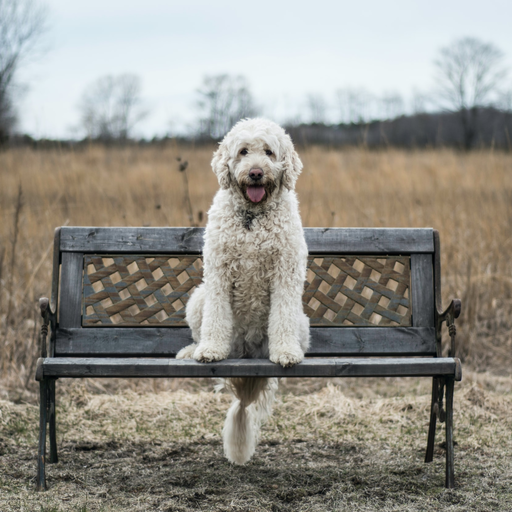

In [13]:
image

In [14]:
result

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [15]:
import tensorflow as tf

image = tf.convert_to_tensor(image)
mask = tf.convert_to_tensor(result)

In [16]:
image.shape

TensorShape([512, 512, 3])

In [17]:
mask.shape

TensorShape([512, 512])

In [18]:
import tensorflow as tf
from tensorflow import keras

class GroupNormalization(tf.keras.layers.Layer):
    """GroupNormalization layer.
    This layer is only here temporarily and will be removed
    as we introduce GroupNormalization in core Keras.
    """

    def __init__(
        self,
        groups=32,
        axis=-1,
        epsilon=1e-5,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon

    def build(self, input_shape):
        dim = input_shape[self.axis]
        self.gamma = self.add_weight(
            shape=(dim,),
            name="gamma",
            initializer="ones",
        )
        self.beta = self.add_weight(
            shape=(dim,),
            name="beta",
            initializer="zeros",
        )

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        reshaped_inputs = self._reshape_into_groups(inputs, input_shape)
        normalized_inputs = self._apply_normalization(reshaped_inputs, input_shape)
        return tf.reshape(normalized_inputs, input_shape)

    def _reshape_into_groups(self, inputs, input_shape):
        group_shape = [input_shape[i] for i in range(inputs.shape.rank)]
        group_shape[self.axis] = input_shape[self.axis] // self.groups
        group_shape.insert(self.axis, self.groups)
        group_shape = tf.stack(group_shape)
        return tf.reshape(inputs, group_shape)

    def _apply_normalization(self, reshaped_inputs, input_shape):
        group_reduction_axes = list(range(1, reshaped_inputs.shape.rank))
        axis = -2 if self.axis == -1 else self.axis - 1
        group_reduction_axes.pop(axis)
        mean, variance = tf.nn.moments(
            reshaped_inputs, group_reduction_axes, keepdims=True
        )
        gamma, beta = self._get_reshaped_weights(input_shape)
        return tf.nn.batch_normalization(
            reshaped_inputs,
            mean=mean,
            variance=variance,
            scale=gamma,
            offset=beta,
            variance_epsilon=self.epsilon,
        )

    def _get_reshaped_weights(self, input_shape):
        broadcast_shape = self._create_broadcast_shape(input_shape)
        gamma = tf.reshape(self.gamma, broadcast_shape)
        beta = tf.reshape(self.beta, broadcast_shape)
        return gamma, beta

    def _create_broadcast_shape(self, input_shape):
        broadcast_shape = [1] * input_shape.shape.rank
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(self.axis, self.groups)
        return broadcast_shape

class PaddedConv2D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding=0, strides=1, **kwargs):
        super().__init__(**kwargs)
        self.padding2d = keras.layers.ZeroPadding2D(padding)
        self.conv2d = keras.layers.Conv2D(filters, kernel_size, strides=strides)

    def call(self, inputs):
        x = self.padding2d(inputs)
        return self.conv2d(x)        

class AttentionBlock(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.norm = GroupNormalization(epsilon=1e-5)
        self.q = PaddedConv2D(output_dim, 1)
        self.k = PaddedConv2D(output_dim, 1)
        self.v = PaddedConv2D(output_dim, 1)
        self.proj_out = PaddedConv2D(output_dim, 1)

    def call(self, inputs):
        x = self.norm(inputs)
        q, k, v = self.q(x), self.k(x), self.v(x)

        # Compute attention
        _, h, w, c = q.shape
        q = tf.reshape(q, (-1, h * w, c))  # b, hw, c
        k = tf.transpose(k, (0, 3, 1, 2))
        k = tf.reshape(k, (-1, c, h * w))  # b, c, hw
        y = q @ k
        y = y * (c**-0.5)
        y = keras.activations.softmax(y)

        # Attend to values
        v = tf.transpose(v, (0, 3, 1, 2))
        v = tf.reshape(v, (-1, c, h * w))
        y = tf.transpose(y, (0, 2, 1))
        x = v @ y
        x = tf.transpose(x, (0, 2, 1))
        x = tf.reshape(x, (-1, h, w, c))
        return self.proj_out(x) + inputs

class ResnetBlock(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.norm1 = GroupNormalization(epsilon=1e-5)
        self.conv1 = PaddedConv2D(output_dim, 3, padding=1)
        self.norm2 = GroupNormalization(epsilon=1e-5)
        self.conv2 = PaddedConv2D(output_dim, 3, padding=1)

    def build(self, input_shape):
        if input_shape[-1] != self.output_dim:
            self.residual_projection = PaddedConv2D(self.output_dim, 1)
        else:
            self.residual_projection = lambda x: x

    def call(self, inputs):
        x = self.conv1(keras.activations.swish(self.norm1(inputs)))
        x = self.conv2(keras.activations.swish(self.norm2(x)))
        return x + self.residual_projection(inputs)                

In [19]:
from tensorflow import keras
import keras_cv

class ImageEncoder(keras.Sequential):
    """ImageEncoder is the VAE Encoder for StableDiffusion."""

    def __init__(self, img_height=512, img_width=512, download_weights=True):
        super().__init__(
            [
                keras.layers.Input((img_height, img_width, 3)),
                PaddedConv2D(128, 3, padding=1),
                ResnetBlock(128),
                ResnetBlock(128),
                PaddedConv2D(128, 3, padding=1, strides=2),
                ResnetBlock(256),
                ResnetBlock(256),
                PaddedConv2D(256, 3, padding=1, strides=2),
                ResnetBlock(512),
                ResnetBlock(512),
                PaddedConv2D(512, 3, padding=1, strides=2),
                ResnetBlock(512),
                ResnetBlock(512),
                ResnetBlock(512),
                AttentionBlock(512),
                ResnetBlock(512),
                GroupNormalization(epsilon=1e-5),
                keras.layers.Activation("swish"),
                PaddedConv2D(8, 3, padding=1),
                PaddedConv2D(8, 1),
                # TODO(lukewood): can this be refactored to be a Rescaling layer?
                # Perhaps some sort of rescale and gather?
                # Either way, we may need a lambda to gather the first 4 dimensions.
                keras.layers.Lambda(lambda x: x[..., :4] * 0.18215),
            ]
        )

        if download_weights:
            image_encoder_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/vae_encoder.h5",
                file_hash="c60fb220a40d090e0f86a6ab4c312d113e115c87c40ff75d11ffcf380aab7ebb",
            )
            self.load_weights(image_encoder_weights_fpath)

In [20]:
import tensorflow as tf

image_encoder = ImageEncoder()

image = tf.squeeze(image)
image = tf.cast(image, dtype=tf.float32) / 255.0 * 2.0 - 1.0
image = tf.expand_dims(image, axis=0)
known_x0 = image_encoder(image)
if image.shape.rank == 3:
    known_x0 = tf.repeat(known_x0, BATCH_SIZE, axis=0)

mask = tf.expand_dims(mask, axis=-1)
mask = tf.expand_dims(mask, axis=0)
mask = tf.cast(
    tf.nn.max_pool2d(mask, ksize=8, strides=8, padding="SAME"),
    dtype=tf.float32,
)
mask = tf.squeeze(mask)
if mask.shape.rank == 2:
    mask = tf.repeat(tf.expand_dims(mask, axis=0), BATCH_SIZE, axis=0)
mask = tf.expand_dims(mask, axis=-1)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [21]:
known_x0.shape, mask.shape

(TensorShape([1, 64, 64, 4]), TensorShape([4, 64, 64, 1]))

In [22]:
import math

from keras_cv.models.generative.stable_diffusion.constants import _ALPHAS_CUMPROD
from keras_cv.models.generative.stable_diffusion.diffusion_model import DiffusionModel

seed = None

num_steps = 25
unconditional_guidance_scale = 7.5

num_resamples = 1
MAX_PROMPT_LENGTH = 77

diffusion_model = DiffusionModel(img_height, img_width, MAX_PROMPT_LENGTH)
diffusion_model_weights_fpath = keras.utils.get_file(
    origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/kcv_diffusion_model.h5",
    file_hash="8799ff9763de13d7f30a683d653018e114ed24a6a819667da4f5ee10f9e805fe",
)
diffusion_model.load_weights(diffusion_model_weights_fpath)

verbose = True

def _get_initial_diffusion_noise(batch_size, seed):
    if seed is not None:
        return tf.random.stateless_normal(
            (batch_size, img_height // 8, img_width // 8, 4),
            seed=[seed, seed],
        )
    else:
        return tf.random.normal(
            (batch_size, img_height // 8, img_width // 8, 4)
        )

def _get_initial_alphas(timesteps):
    alphas = [_ALPHAS_CUMPROD[t] for t in timesteps]
    alphas_prev = [1.0] + alphas[:-1]

    return alphas, alphas_prev

def _get_timestep_embedding(timestep, batch_size, dim=320, max_period=10000):
    half = dim // 2
    freqs = tf.math.exp(
        -math.log(max_period) * tf.range(0, half, dtype=tf.float32) / half
    )
    args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
    embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
    embedding = tf.reshape(embedding, [1, -1])
    return tf.repeat(embedding, batch_size, axis=0)

latent = _get_initial_diffusion_noise(BATCH_SIZE, seed)

timesteps = tf.range(1, 1000, 1000 // num_steps)
alphas, alphas_prev = _get_initial_alphas(timesteps)
if verbose:
    progbar = keras.utils.Progbar(len(timesteps))
    iteration = 0

for index, timestep in list(enumerate(timesteps))[::-1]:
    a_t, a_prev = alphas[index], alphas_prev[index]
    latent_prev = latent  # Set aside the previous latent vector
    t_emb = _get_timestep_embedding(timestep, BATCH_SIZE)

    for resample_index in range(num_resamples):
        unconditional_latent = diffusion_model.predict_on_batch(
            [latent, t_emb, unconditional_context]
        )
        latent = diffusion_model.predict_on_batch([latent, t_emb, context])
        latent = unconditional_latent + unconditional_guidance_scale * (
            latent - unconditional_latent
        )
        pred_x0 = (latent_prev - math.sqrt(1 - a_t) * latent) / math.sqrt(a_t)
        latent = latent * math.sqrt(1.0 - a_prev) + math.sqrt(a_prev) * pred_x0

        # Use known image (x0) to compute latent
        if timestep > 1:
            noise = tf.random.normal(tf.shape(known_x0), seed=seed)
        else:
            noise = 0.0
        known_latent = (
            math.sqrt(a_prev) * known_x0 + math.sqrt(1 - a_prev) * noise
        )
        # Use known latent in unmasked regions
        latent = mask * known_latent + (1 - mask) * latent
        # Resample latent
        if resample_index < num_resamples - 1 and timestep > 1:
            beta_prev = 1 - (a_t / a_prev)
            latent_prev = tf.random.normal(
                tf.shape(latent),
                mean=latent * math.sqrt(1 - beta_prev),
                stddev=math.sqrt(beta_prev),
                seed=seed,
            )

    if verbose:
        iteration += 1
        progbar.update(iteration)

25/25 [==============================] - 93s 3s/step


In [23]:
latent_b64 = base64.b64encode(latent.numpy().tobytes())
latent_b64str = latent_b64.decode()

In [24]:
REPO_ID = "keras-sd/decoder"

In [30]:
!git clone https://huggingface.co/{REPO_ID}

fatal: destination path 'decoder' already exists and is not an empty directory.


In [25]:
import importlib

handler = importlib.import_module("decoder.handler")
# latent = response

# init pipeline
my_handler = handler.EndpointHandler(path=".")

# prepare sample playoad
payload = {"inputs": latent_b64str,
           "batch_size": 4}

# test the pipeline
response = my_handler(payload)

In [26]:
import base64
import numpy as np

images = base64.b64decode(response)
images = np.frombuffer(images, dtype="uint8")
images = np.reshape(images, (BATCH_SIZE, 512, 512, 3))

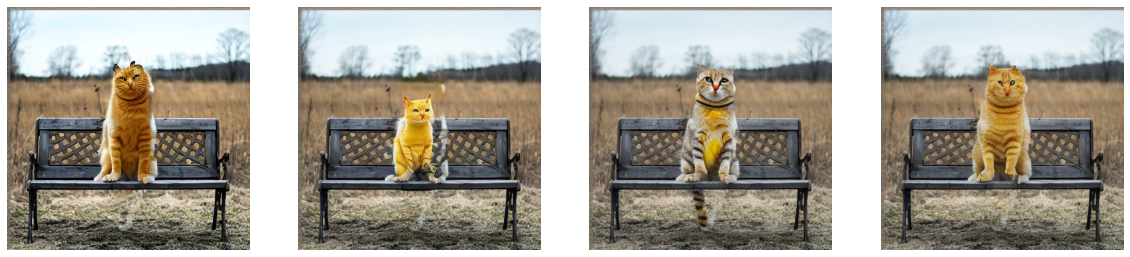

In [27]:
plot_images(images)